<a href="https://colab.research.google.com/github/nadnik13/sparse_grid/blob/main/ClusteringImageFirstTry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
%matplotlib inline

In [ ]:
# https://graphsandnetworks.com/using-laplacians-for-graph-learning/
# https://graphsandnetworks.com/the-cora-dataset/
# https://colab.research.google.com/github/borglab/gtsam.org/blob/master/notebooks/Laplacian.ipynb#scrollTo=qc28a2XXfRwt
# https://towardsdatascience.com/graph-laplacian-and-its-application-in-machine-learning-7d9aab021d16


# Laplacian Eigenmaps and Spectral Techniques for Embedding and Clustering

In [4]:
from google.colab import files

In [13]:
uploaded = files.upload()

Saving cora.cites to cora.cites
Saving cora.content to cora.content


In [68]:
# data_dir = os.path.expanduser("~/")
# cora_location = os.path.expanduser(os.path.join(data_dir, "cora.cites"))
g_nx = nx.read_edgelist(path="cora.cites")
# cora_data_location = os.path.expanduser(os.path.join(data_dir, "cora.content"))

node_attr = pd.read_csv("cora.content", sep='\t', header=None)
values = { str(row.tolist()[0]): row.tolist()[-1] for _, row in node_attr.iterrows()}
nx.set_node_attributes(g_nx, values, 'subject')
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]

node_data = pd.read_table("cora.content", header=None, names=column_names)


In [70]:
g_nx_ccs = (g_nx.subgraph(c).copy() for c in nx.connected_components(g_nx))
g_nx = max(g_nx_ccs, key=len)
node_ids = list(g_nx.nodes())
print("Largest subgraph statistics: {} nodes, {} edges".format(
        g_nx.number_of_nodes(), g_nx.number_of_edges()))
node_targets = [ g_nx.nodes[node_id]['subject'] for node_id in node_ids]

Largest subgraph statistics: 2485 nodes, 5069 edges


In [71]:
node_data

,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,...,w_1424,w_1425,w_1426,w_1427,w_1428,w_1429,w_1430,w_1431,w_1432,subject
31336,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1061127,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
1106406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
13195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
37879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128975,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
1128977,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
1128978,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
117328,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Case_Based


In [73]:
A = nx.to_numpy_array(g_nx)
A.shape

(2485, 2485)

In [74]:
A.shape

(2485, 2485)

In [75]:
D = np.diag(A.sum(axis=1))
print(D)

[[168.   0.   0. ...   0.   0.   0.]
 [  0.   5.   0. ...   0.   0.   0.]
 [  0.   0.   6. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   4.   0.   0.]
 [  0.   0.   0. ...   0.   4.   0.]
 [  0.   0.   0. ...   0.   0.   2.]]


In [76]:
L = D-A
print(L)

[[168.  -1.  -1. ...   0.   0.   0.]
 [ -1.   5.   0. ...   0.   0.   0.]
 [ -1.   0.   6. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   4.  -1.  -1.]
 [  0.   0.   0. ...  -1.   4.   0.]
 [  0.   0.   0. ...  -1.   0.   2.]]


# Eigenvectors and eigenvalues of the Laplacian

In [77]:
eigenvalues, eigenvectors = np.linalg.eig(L)

In [78]:
eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)

# Let’s also order the eigenvalues from small to large:

In [79]:
order = np.argsort(eigenvalues)
eigenvalues = eigenvalues[order]

In [80]:
 eigenvalues[0:10]

array([3.55271279e-15, 1.48014820e-02, 2.36128446e-02, 3.03008575e-02,
       4.06458495e-02, 4.72354991e-02, 5.65503673e-02, 6.00350936e-02,
       7.24399539e-02, 7.45956530e-02])

The first eigenvalue is as good as zero and this is a general fact; the smallest eigenvalue is always zero. The reason it’s not exactly zero above is because of computational accuracy.
So, we will omit the first eigenvector since it does not convey any information.
We also take a 32-dimensional subspace of the full vector space:

In [81]:
embedding_size = 32
v_0 = eigenvectors[:, order[0]]
v = eigenvectors[:, order[1:(embedding_size+1)]]

In [82]:
eigenvalues.shape

(2485,)

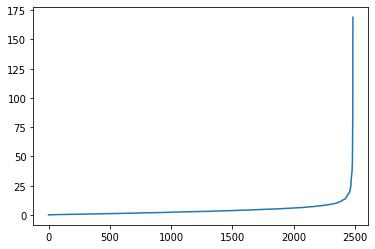

In [83]:
plt.plot(eigenvalues)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


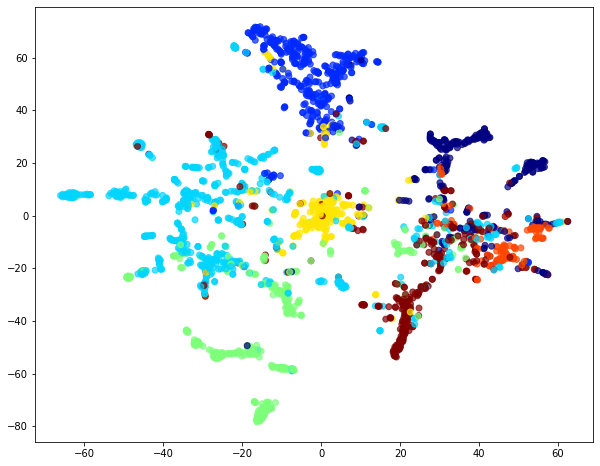

In [84]:
tsne = TSNE()
v_pr = tsne.fit_transform(v)
alpha=0.7
label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [ label_map[target] for target in node_targets]
fig = plt.figure(figsize=(10,8))
plt.scatter(v_pr[:,0],v_pr[:,1],c=node_colours, cmap="jet", alpha=alpha)

In [85]:
X = v
Y = np.array(node_targets)
clf = RandomForestClassifier(n_estimators=10, min_samples_leaf=4)
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=140, random_state=42)

In [ ]:
node_targets

In [87]:
clf.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=4, n_estimators=10)

In [92]:
np.array(node_targets)[:10]

array(['Genetic_Algorithms', 'Genetic_Algorithms', 'Neural_Networks',
       'Genetic_Algorithms', 'Genetic_Algorithms', 'Genetic_Algorithms',
       'Genetic_Algorithms', 'Genetic_Algorithms', 'Genetic_Algorithms',
       'Genetic_Algorithms'], dtype='<U22')

In [89]:
print("score on X_train {}".format(clf.score(X_train, y_train)))
print("score on X_test {}".format(clf.score(X_test, y_test)))

score on X_train 0.8714285714285714
score on X_test 0.7339019189765459


In [93]:
uploaded = files.upload()

Saving 2000px-Python-logo-notext.png to 2000px-Python-logo-notext.png


In [95]:
from matplotlib import image
from mpl_toolkits.mplot3d import Axes3D

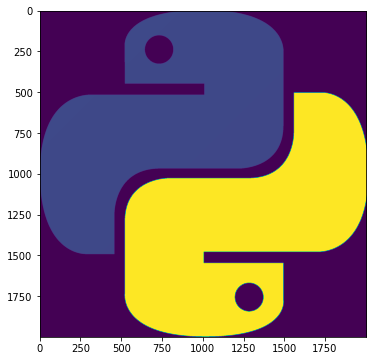

In [105]:
# dem = image.imread('2000px-Python-logo-notext.png')
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(dem[:,:,0]);

In [106]:
type(dem[:,:,0])
dem[:,:,0].shape

(2000, 2000)

In [107]:
A = dem[:,:,0]

In [108]:
D = np.diag(A.sum(axis=1))
print(D)

[[23.5451    0.        0.       ...  0.        0.        0.      ]
 [ 0.       33.721573  0.       ...  0.        0.        0.      ]
 [ 0.        0.       41.305885 ...  0.        0.        0.      ]
 ...
 [ 0.        0.        0.       ... 46.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]]


In [109]:
L = D-A
print(L)

[[23.5451    0.        0.       ...  0.        0.        0.      ]
 [ 0.       33.721573  0.       ...  0.        0.        0.      ]
 [ 0.        0.       41.305885 ...  0.        0.        0.      ]
 ...
 [ 0.        0.        0.       ... 46.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]]


In [110]:
eigenvalues, eigenvectors = np.linalg.eig(L)

In [111]:
eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)

In [112]:
order = np.argsort(eigenvalues)
eigenvalues = eigenvalues[order]

In [113]:
 eigenvalues[0:10]

array([ 0.       ,  0.       ,  0.3009687, 23.552702 , 33.7313   ,
       41.317005 , 46.10448  , 47.111805 , 52.213905 , 56.889194 ],
      dtype=float32)

In [114]:
embedding_size = 32
v_0 = eigenvectors[:, order[0]]
v = eigenvectors[:, order[1:(embedding_size+1)]]

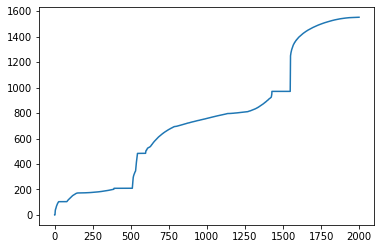

In [115]:
plt.plot(eigenvalues)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


TypeError: ignored

In [120]:
# Get smallest non-zero eigen value's index for obtaining partition to cluster
fiedler_index = sorted_indices[1]

# The eigen vector for smallest non-zero eigen value i.e plotting the Fiedler vector
plt.figure(figsize=(8,6))
plt.scatter(np.arange(data_size), evecs[:,fiedler_index].tolist())
plt.title("Eigen (Fiedler) vector plot")
plt.show()
fiedler_vector = evecs[:,fiedler_index].copy()

# Thresholding the values in this eigen vector at 0
fiedler_vector[fiedler_vector < 0.0] = 0
fiedler_vector[fiedler_vector > 0.0] = 1
new_labels = np.asarray(fiedler_vector)[:,0]
# Plot cluster result
plt.scatter(features[:,0], features[:,1],         
                          c=new_labels.astype(float))
plt.title("Clusters plot")
plt.show()

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8}

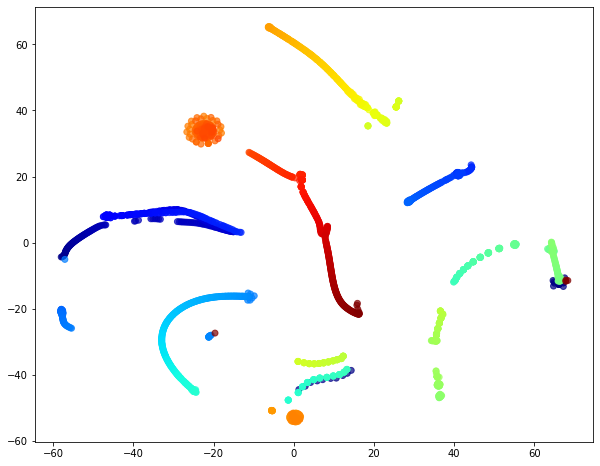

In [123]:
label_map = { l: i for i, l in enumerate(range(0,2000))}
node_colours = [ label_map[target] for target in  range(0,2000)]
fig = plt.figure(figsize=(10,8))
plt.scatter(v_pr[:,0],v_pr[:,1],c=node_colours, cmap="jet", alpha=alpha)